# Imputation Simulation

Made by: Sarah Odell

github: https://github.com/sarahodell

Summary: This pipeline simulates either recombinant inbred lines or MAGIC (Multi-parent advanced generation intercross) lines using HapMap data from the 26 founder lines of the maize Nested Association Mapping (NAM) population (More information at <a href='https://www.panzea.org/genotypes'>panzea.org</a>). This is done only for chromosome 10. The imputation accuracy of the <a href='https://bitbucket.org/tasseladmin/tassel-5-source/wiki/UserManual/FILLIN/FILLIN' >FILLIN</a> tool (part of TASSEL 5) is quantified as the percentage of imputed blocks assigned to the correct parental haplotype. 

Workflow:
1. <a href='#section_1'>Simulate Samples</a>
2. <a href='#section_2'>Write outfile</a>
3. <a href='#section_3'>Build simulated vcf files</a>
4. <a href='#section_4'>Merge vcf files for all samples</a>
5. <a href='#section_5'>Run FILLIN on merged vcf file</a>
6. <a href='#section_6'>Assess imputation accuracy</a>

In [6]:
import  time
import  platform
print('Last updated: %s' %time.strftime('%d/%m/%Y'))
print('Created using Python', platform.python_version())

Last updated: 15/06/2018
('Created using Python', '2.7.13')


<a id='section_1'></a>

### How to get the data:
Information on where to find data files, how I filtered them, and how to install TASSEL are all in [FILLINStart](FILLINStart.html)

## 1. Simulate Samples

Recombination probability is approximated based on centromere position (B73 v3), 

In [5]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [6]:
def chrom_info(chro_num):
    """chro_num: chromosome number (int)
    Outputs:
    xo_prob: a probability distribution function for crossover events on
    that chromosome based on chromosome length and centromere position 
    (list of floats)
    end: (int) the approximate end of the chromosome, in Mb
    """
    cent = pd.read_table('B73v4centromeres.txt',sep='\t')
    cdf = cent[cent['chr']==chro_num]
    end = int(cdf['v3chr.end'].values[0])
    centstart = int(cdf['v3start'].values[0])
    centend= int(cdf['v3end'].values[0])
    centlen = int(round(cdf['v3size'].values[0]))
    if end-centend > centstart:
        longarm = end-centend
        shortarm = centstart
    else:
        longarm = centstart
        shortarm = end-centend
    diff = longarm-shortarm
    a = [i**2 for i in list(reversed(range(0,centstart+1)))]
    c = [0.0 for i in range(centlen)]
    b = [i**2 for i in range(longarm)]
    xo_prob = a+c+b
    if len(xo_prob)>= end:
        xo_prob=xo_prob[:end]
    xo_prob = [float(j)/sum(xo_prob) for j in xo_prob]
    return xo_prob,end

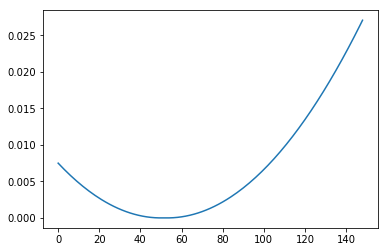

In [7]:
xo_prob,end = chrom_info(10)
plot(xo_prob)

In [9]:
nam_founders = ['CML322','CML333','Oh43','Oh7B','CML52','CML69','CML103','CML228','Tzi8',
 'B97','NC350','NC358','CML247','CML277','M162W','Ky21','M37W','Il14H',
 'Hp301','Ki3','Ki11','MS71','Mo18W','P39','Tx303']

def chrom_sim(pnum,c=10):
    """
    pnum: (int) Number of parents to start with. Parents are randomly selected
    from the 26 NAM founders
    c: chromosome number (1..10 for maize)
    Outputs a 2-D list of length pnum. Internal lists contain strings 
    assigning parental donor for 1Mb blocks (i.e. list[0]= ['B73','B73',...])"""
    pop=[]
    parents = random.choice(nam_founders,pnum,replace=False)
    for i in parents:
        xo_prob,end=chrom_info(c)
        p = []
        for j in range(end+1):
            p.append(i)
        pop.append(p)
    return pop

In [14]:
pop = chrom_sim(16)
#First parent is P39, chromosome 10 is 150 Mb long, broken up into 1Mb blocks
pop[0][:10], len(pop[0])

(['P39', 'P39', 'P39', 'P39', 'P39', 'P39', 'P39', 'P39', 'P39', 'P39'], 150)

For the sake of reproduction, when simulating my MAGIC population, below are the 16 parents that I started with. The final lines are in 'Actual_MAGIC1.txt', and this file will be used for the following sections

In [10]:
parents=['Hp301', 'CML69', 'CML52', 'CML247', 'Ki3', 'CML277', 'Tzi8',
       'Il14H', 'Ky21', 'CML103', 'CML322', 'CML333', 'Ki11', 'Tx303',
       'Oh7B', 'MS71']

In [16]:
def crossover(n,parents,c=10):
    """
    Simulates a crossover event of a chromosome, returns the 'f1'
    Input:
    n: (int) number of f1 samples to produce
    parents: 2-D list of length 2, output of chrom_sim() (i.e. chromsim(16)[:2])
    c: chromosome number 
    
    Output:
    If n==1, 1-D list with f1
    If n>1, 2-D list of f1s
    """
    f1s = []
    for i in range(n):
        xo_prob,end=chrom_info(c)
        site = [s for s in range(end)]
        f1=[]
        #randomly choose a parent to start with
        if numpy.random.random_sample() >= 0.5:
            donor = parents[0]
        else:
            donor = parents[1]
        #Either 1 or 2 crossover events per chromosome
        xo = random.poisson(1.5)
        draw = numpy.random.choice(site,size=xo,p=xo_prob)
        #If 2 or more crossovers, simulate interference by making them 
        # at least 40 Mb away from each other
        if xo >= 2:
            draw = sorted(draw)
            first = draw[0]
            while abs(draw[1] - draw[0]) < 40:
                draw = [draw[0],numpy.random.choice(site,p=xo_prob)]
        
        #iterate through and take sections from each parent
        start = 0
        for d in draw:
            f1+=donor[start:d]
            start=d
            if donor==parents[0]:
                donor=parents[1]
            elif donor==parents[1]:
                donor=parents[0]
        f1+=donor[start:]
        f1s.append(f1)
    if n==1:
        return f1
    else:
        return f1s

In [17]:
def make_magic(parents,c=10,n=1):
    """ Simulates MAGIC lines
    Input:
    parents: (list)2-D list of parent chromosomes (length must be even
    output of chrom_sim
    c: chromosome number (Default: 10)
    n: number of f1 samples to make per parent cross (Default: 1)
    
    Output:
    2-D list of length(n), simulated chromosomes
    """
    if len(parents)==2:
        return crossover(n,parents)
    rounds = []
    for i in range(0,len(parents),2):
        rounds.append(crossover(n,parents[i:i+2]))
    return make_magic(rounds)

In [22]:
f = [make_magic(pop) for i in range(10)]
len(f)

10

In [21]:
f[2][:10]

['Tx303',
 'Tx303',
 'Tx303',
 'Tx303',
 'Tx303',
 'Tx303',
 'Tx303',
 'B97',
 'B97',
 'B97']

Here is a representation of the chromosomes we simulated. Info on how I made this image here: [SimulateMAGIC](SimulateMAGIC.ipynb)

![title](MAGICimage.png)

<a id='section_2'></a>

## 2. Write outfile

Now that we have simulated "chromosomes" for the MAGIC lines, we want to identify breakpoints and parental donor, and then write this out to a file so that we can turn these into actual vcf files.

In [23]:
def locations(r,c=10):
    """Identifies chromosome breakpoints and returns a list of format:
    [[chr,start,end,donor],...]
    Input: (list) simulated chromosome (i.e. f[0])
    """
    locs=[]
    last = r[0]
    counter = 0
    for i in range(len(r)):
        if r[i] != last:
            start = i
            locs.append([c,counter*1e6,(start*1e6)-1,last])
            counter=start
            last = r[i]
    locs.append([c,start*1e6,len(r)*1e6,last])
    return locs

In [ ]:
def make_outfile(ril,out):
    """ Writes out file in format: 
    out: name of outfile (str)
    """
    txt = 'sample\tchr\tstart\tend\tdonor\n'
    count=1
    for j in ril:
        locs = locations(j)
        for l in locs:
            txt+='{0}\t{1}\t{2}\t{3}\t{4}\n'.format('M'+str(count),l[0],int(l[1]),int(l[2]),l[3])
        count+=1
    with open(out,'w') as outfile:
        outfile.write(txt)

In [ ]:
make_outfile(f,'Actual_MAGIC1.txt')

<a id='section_3'></a>

## 3. Build simulated vcf files

Now that we have our breakpoint files, we can pull variant data from the the donor parent's vcf files (from maize HapMap v3) and put them together into one vcf file for each MAGIC line.

This step requires the following software (versions I used in parentheses):

- bcftools (1.2)
- tabix (0.2.6)
- vcftools (b240116)


The script marker_generator.py reads in the parent vcf file and randomly chooses positions (here I set m to 500,000) to imitate a SNP array. The positions are output into a file c10_markers.txt

In [ ]:
donorfile='hmpv3_founders/hmp3_founders_final.vcf' #path to donor file
markerfile='c10_markers.txt' #name of marker file
m=500000 #number of markers

breakfile = 'Actual_MAGIC1.txt' #Simulated break file (made above)
outbase = 'MAGIC1_10samples.vcf' #desired base name of output files

In [30]:
%run marker_generator.py --help

usage: marker_generator.py [-h] infile outfile m

Program description

positional arguments:
  infile      The input vcf file
  outfile     The output regions file
  m           The number of markers to select

optional arguments:
  -h, --help  show this help message and exit


In [ ]:
%run marker_generator.py donorfile markerfile m

The script build_simvcf.py uses bcftools to pull variants from the indicated donor vcf file at the 500000 marker positions previously generated. The output is a concatenated vcf file for each MAGIC sample with the base filename [sampleid_outfile.vcf]

In [13]:
%run build_simvcf.py --help

usage: build_simvcf.py [-h] infile outfile markerfile

Program description

positional arguments:
  infile      The input breakpoint file (output of write_outfile()
  outfile     The desired output vcf file basename (i.e. basename.vcf)
  markerfile  File with list of marker postions (from marker_generator.py

optional arguments:
  -h, --help  show this help message and exit


In [ ]:
%run build_simvcf.py breakfile outbase markerfile

We should now have 10 vcf files (one for each of our MAGIC lines). However, the vcf files have incorrect headers and may be out of order. In addition, in order to run FILLIN, we want all of our samples in one vcf file. Let's fix that.

<a id='section_4'></a>

## 4. Merge vcf files for all samples

In [ ]:
stamp= time.strftime('%m%d%y')
outdir = 'MAGICSim_'+stamp
finalfile = 'MAGICSimAll_chr10.vcf.gz' #Name of merged vcf file
!mkdir $outdir

In [ ]:

!for i in {1..10};do
    !echo M${i} > $outdir'/M'${i}'.txt'
    !cat M${i}'_'$outbase | vcf-sort | bcftools reheader -s 'M'${i}'.txt' -o $outdir/M${i}'_edit_'$outbase
    !bgzip $outdir'/M'${i}'_edit_'$outbase
    !tabix -p vcf $outdir'/M'${i}'_edit_'$outbase
    !echo $outdir'/M'${i}'_edit_'$outbase >> $outdir'/file_names.txt'
!done    

In [ ]:
!bcftools merge -l $outdir'/file_names.txt' -m all -Oz > $outdir'/'$finalfile

Now we have one vcf file with all of our samples together. Now it's time to IMPUTE!

<a id='section_5'></a>

## 5. Run FILLIN on merged vcf file

For the purposes of assessing imputation accuracy, I will use a flag offered by the FILLINImputationPlugin, -ProjA. By setting it to true, it will output a file with estimated breakpoint positions and donor haplotypes, but does not impute.

In [ ]:
!mkdir $outdir'/FILLIN'
projout = $outdir'/FILLIN/MAGIC1_10samples_chr10_ProjA' #name of projections alignment file
impout = $outdir'/FILLIN/MAGIC1_10samples_chr10_Imputed' #name of imputed file

hapdir = 'chr10haps'
##Set path to tassel here
tassel='tassel-5-standalone/run_pipeline.pl'

In [ ]:
#Running the projection alignment (suppressing system out because it's very long)
!run_pipeline.pl -Xmx32g -FILLINImputationPlugin -hmp $finalfile -d $donorfile -o $projaout -ProjA true -nV true -endPlugin

Then we can actually create the donor haplotypes (this takes a long time, even just for one chromosome) and impute these haplotypes onto our simulated lines.

In [ ]:
# -Nv flag suppresses system out
# -extOut creates a directory with files saying which donors belong to which haplotype blocks

!$tassel -Xmx32g -FILLINFindHaplotypesPlugin -hmp $donorfile -o $hapdir -mxErr 0 -minTaxa 1 -extOut true -nV true -endPlugin

In [ ]:
!$tassel -Xmx32g -FILLINImputationPlugin -hmp $finalfile -d $donorfile -o $impout -nV true -endPlugin

<a id='section_6'></a>

## 6. Assess imputation accuracy

Using the projection alignment output and the known breakpoints from our simulations, we can assess how accurately FILLIN predicted the parental origin of our MAGIC lines across the chromosome. 
This section uses:
- bedtools (2.25)

First thing we want to do is parse the projection alignment file so that it's in a format that can be easily compared to our breakpoint file. 

In [ ]:
from subprocess import Popen, PIPE
import os

In [ ]:
!gunzip $projaout'.pa.txt.gz'

In [29]:
projafile = 'MAGICSim_chr10_IMPUTED.pa.txt'

In [30]:
process = Popen(['awk','/#Donor Haplotypes/{flag=1;next}/#Taxa Breakpoints/{flag=0}flag',projafile],stdout=PIPE,stderr=PIPE)
stdout,sterr=process.communicate()

In [31]:
#The ProjA file uses number codes for the donors
#Make a dictionary of all the donors and their associated keys
donors={}
for i in stdout.split('\n')[:-1]:
    line = i.split('\t')
    donors[line[0]]=line[1]

In [32]:
donors

{'0': 'B73',
 '1': 'B97',
 '10': 'HP301',
 '11': 'Il14H',
 '12': 'KI3',
 '13': 'Ki11',
 '14': 'Ky21',
 '15': 'M37W',
 '16': 'M162W',
 '17': 'MO18W',
 '18': 'Ms71',
 '19': 'NC350',
 '2': 'CML52',
 '20': 'NC358',
 '21': 'Oh7B',
 '22': 'Oh43',
 '23': 'P39',
 '24': 'Tx303',
 '25': 'Tzi8',
 '3': 'CML69',
 '4': 'CML103',
 '5': 'CML228',
 '6': 'CML247',
 '7': 'CML277',
 '8': 'CML322',
 '9': 'CML333'}

In [33]:
#Now parse out the assignment blocks
process = Popen(['awk','/#Block are defined chr:startPos:endPos:donor1:donor2/{flag=1;next}/,0/{flag=0}flag',projafile],stdout=PIPE,stderr=PIPE)
stdout,sterr=process.communicate()

The format of the second half of the ProjA file is as follows:
sample_id\tchr:start:end:donor1:donor2

If donor1 and donor2 are not the same, then this means that for that chromosome segment, FILLIN 
predicted heterozygosity. We see this sometimes, even if we don't want it to be so... I'm still figuring it out

In [35]:
breakpoints = []
for i in stdout.split('\n')[:-1]:
    line = i.split('\t')
    brks = {}
    sample=line[0]
    for j in line[1:-1]:
        info=j.split(':')
        chrom=info[0]
        start=info[1]
        end=info[2]
        donor1=info[3]
        donor2=info[4]
        brks = {'sample':sample, 'chr':chrom, 'start':start, 'end':end, 'donor1': donors[donor1], 'donor2':donors[donor2]}
        breakpoints.append(brks)

In [36]:
breakpoints[0]

{'chr': '10',
 'donor1': 'HP301',
 'donor2': 'Il14H',
 'end': '129276856',
 'sample': 'M7',
 'start': '129240606'}

In [39]:
#turn the dictionary into a pandas dataframe
df = pd.DataFrame(breakpoints)
proja = df[['sample','chr','start','end','donor1','donor2']]

In [40]:
proja.head()

,sample,chr,start,end,donor1,donor2
0,M7,10,129240606,129276856,HP301,Il14H
1,M10,10,13842144,14149931,B73,Oh43
2,M10,10,113774299,114297964,B73,Oh7B
3,M10,10,114299498,114304786,B73,Oh43
4,M10,10,114304905,114313731,B73,Oh7B


In [41]:
#Write it out to a file
proja.to_csv('Predicted_MAGIC1.txt',sep='\t')

### Accounting for this heterozygosity...

One possible reason that FILLIN couldn't choose between donors in these regions is that more than one parent shared a haplotype in that regions. 
Using the extOut/ directory produced from the imputation, I can check to see if this is correct.

### Calculating percentage correctly assigned

The script intersect.py used bedtools to determine the proportion of the chromosome that was correctly assigned by FILLIN (of what was predicted; this does not count regions where FILLIN could not reach a conclusion)

Using --verbose outputs a full report on each individual and percentage per parent in a file called intersect_output.txt. 
Otherwise, a total percentage is printed to stdout

In [ ]:
haplotypes={}
#Directory in the haplotype directory created by FILLINFindHaplotypesPlugin
for filename in os.listdir(hapdir+'/extOut'):
    hapname=filename.split('.')[1]
    haplotypes[hapname]={}
    with open('../extOut/'+filename,'r') as infile:
        for line in infile:
            l = line.split('\t')
            h = l[0]
            haplotypes[hapname][h]=[]
            for i in l[1:]:
                haplotypes[hapname][h].append(i.rstrip())

So now we have the parents that belong to each haplotype block. Now we need the chromosomal 
locations of those haplotype blocks. These, we can get from the files within the haplotype directory by grapping the first and last positions listed in each file.

In [ ]:
!cd $hapdir
!echo -e "haplotype\tstart\tend" > 'hap_locs.txt'
!for file in *; do
    !name=$(echo $file | cut -d'.' -f2)
    !start=$(sed -n '2{p;q;}' $file | cut -f4) 
    !end=$(tail -n 1 $file | cut -f4)
    !echo -e "$name\t$start\t$end" >> 'hap_locs.txt'
!done

In [44]:
haplocs = pd.read_csv('hap_locs.txt',sep='\t')
haplocs=haplocs.iloc[:-1,]
haplocs.tail()

,haplotype,start,end
726,gc10s96,18942609.0,19129946.0
727,gc10s97,19129947.0,19249118.0
728,gc10s98,19249119.0,19383688.0
729,gc10s99,19383696.0,19528151.0
730,gc10s9,2052404.0,2159273.0


In [ ]:
#can add positions to the haplotype dictionary
for index,row in haplocs.iterrows():
    hapname=row['haplotype']
    haplotypes[hapname]['start'] = int(row['start'])
    haplotypes[hapname]['end'] = int(row['end'])

In [ ]:
#Can save this dictionary as an object for later use
np.save('extOut_haplotypes.npy', haplotypes)

In [47]:
#And now we can load it again...
haplotypes = np.load('../extOut_haplotypes.npy').item()

With our haplotype information, we can look and see if more than one parent was assigned to the 
same haplotype. Although this shouldn't be the case, it's good to check...

And no, there are no haplotype blocks with more than one parent.

In [49]:
more=[]
for h in haplotypes:
    for j in haplotypes[h].keys():
        if j!= 'start' and j!='end':
            if len(haplotypes[h][j]) > 1:
                more.append(h)
len(more)

0

Now I need to figure out how to deal with two donors. If neither of them are correct, then it's completely wrong, but if one of the two predicted donors is right, what then? 

If one of two donors is correct, use only write donor, but weight the result somehow

In [42]:
%run intersect.py --help

usage: intersect.py [-h] [--verbose VERBOSE] actual pred

Program description

positional arguments:
  actual             Bed file of actual parental assignments
  pred               Bed file of predicted parental assignments

optional arguments:
  -h, --help         show this help message and exit
  --verbose VERBOSE  Print out full output, with per parent percentages


In [ ]:
%run intersect.py Actual_MAGIC1.txt Predicted_MAGIC1.txt